# CVI Experiment Suite

This notebook runs a comprehensive grid search over Characteristic Value Iteration (CVI) hyperparameters and compares performance against classical baselines (VI, Monte Carlo).

In [19]:
# Setup Python path to find cvi_rl modules
import sys
import os

# Add the cvi_rl directory to Python path
notebook_dir = os.path.abspath('')
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)
    
print(f"Added to Python path: {notebook_dir}")
print(f"Current working directory: {os.getcwd()}")


Added to Python path: /network/scratch/b/baldelld/RL/cvi_rl
Current working directory: /network/scratch/b/baldelld/RL/cvi_rl


In [20]:
import numpy as np
import itertools
import pandas as pd
import gymnasium as gym
from tqdm.notebook import tqdm

# CVI Imports
from cvi_rl.envs.registry import make_env
from cvi_rl.algorithms.tabular_vi import value_iteration
from cvi_rl.algorithms.mc import evaluate_policy_monte_carlo
from cvi_rl.algorithms.tabular_cvi import cvi_policy_evaluation, cvi_action_evaluation_from_V, collapse_q_cf_to_scalar_mean
from cvi_rl.cf.grids import make_omega_grid

## 1. Environment Setup

We use a standard tabular environment. Valid options: `"taxi"`, `"gridworld"`, `"frozenlake-8x8"`.

In [21]:
# Verify Q_vi computation explicitly
print("Computing Q-values from V-values...")
print(f"env_spec.n_states: {env_spec.n_states}")
print(f"env_spec.n_actions: {env_spec.n_actions}")
print(f"V_vi shape: {V_vi.shape}")

# Recompute Q_vi with error handling
try:
    Q_vi = np.zeros((env_spec.n_states, env_spec.n_actions))
    
    for s in range(env_spec.n_states):
        for a in range(env_spec.n_actions):
            q_val = 0.0
            for prob, next_state, reward, done in env_spec.P[s][a]:
                q_val += prob * (reward + GAMMA * V_vi[next_state] * (1 - done))
            Q_vi[s, a] = q_val
    
    print(f"✓ Q_vi created successfully!")
    print(f"  Shape: {Q_vi.shape}")
    print(f"  Mean: {Q_vi.mean():.4f}")
    print(f"  Min: {Q_vi.min():.4f}")
    print(f"  Max: {Q_vi.max():.4f}")
    
except Exception as e:
    print(f"✗ Error computing Q_vi: {e}")
    import traceback
    traceback.print_exc()


Computing Q-values from V-values...
env_spec.n_states: 500
env_spec.n_actions: 6
V_vi shape: (500,)
✓ Q_vi created successfully!
  Shape: (500, 6)
  Mean: -1.6753
  Min: -14.4972
  Max: 20.0000


In [22]:
ENV_NAME = "taxi"
GAMMA = 0.9

# Initialize Environment
env_spec, env = make_env(ENV_NAME)
print(f"Initialized {ENV_NAME}: States={env_spec.n_states}, Actions={env_spec.n_actions}")

# Initial Policy (Random)
np.random.seed(42)
random_policy = np.random.randint(0, env_spec.n_actions, size=env_spec.n_states)

# Compute Ground Truth via Classical VI
print("Running Classical Value Iteration for Baseline...")
pi_vi, V_vi, _, _ = value_iteration(env_spec, gamma=GAMMA, termination=1e-8)
print("VI Converged.")

Initialized taxi: States=500, Actions=6
Running Classical Value Iteration for Baseline...
VI Converged.


## 2. Experiment Grid Definition

We define the hyperparameter space for CVI. We will explore:
1. **Grid Construction**: Strategy (Uniform vs Piecewise), Size (K), Range (W)
2. **Interpolation**: Linear, Polar, PCHIP, Lanczos
3. **Collapse Method**: How we extract the scalar mean from the CF (LS, FFT, Gaussian, SavGol)

In [24]:
# Define the parameter grid
param_grid = {
    # Grid Parameters
    "W": [10.0, 20.0],           # Frequency range [-W, W]
    "K": [128, 256, 512],        # Number of grid points
    "grid_strategy": ["uniform", "piecewise_centered"],
    
    # CVI Core Parameters
    "interp_method": ["linear", "polar", "pchip", "lanczos"],
    
    # Post-Processing / Collapse Parameters
    "collapse_method": ["ls", "fft", "gaussian", "savgol"]
}

# Generate all combinations
keys, values = zip(*param_grid.items())
configs = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Filter incompatible combinations if necessary
# e.g., FFT method usually requires uniform grid
filtered_configs = []
for cfg in configs:
    # FFT assumes uniform grid structure for standard inversion
    if cfg["collapse_method"] == "fft" and cfg["grid_strategy"] != "uniform":
        continue
        
    # Lanczos interpolation is theoretically best for uniform grids
    if cfg["interp_method"] == "lanczos" and cfg["grid_strategy"] != "uniform":
        continue
        
    filtered_configs.append(cfg)

print(f"Total Configurations to Test: {len(filtered_configs)}")
print("Example Config:", filtered_configs[0])

Total Configurations to Test: 150
Example Config: {'W': 10.0, 'K': 128, 'grid_strategy': 'uniform', 'interp_method': 'linear', 'collapse_method': 'ls'}


## 3. Helper Functions for Evaluation

We define metrics to compare the CVI-derived Q-values against the Classical VI Q-values ($Q_{VI}$).

In [25]:
def evaluate_config(config, env_spec, policy, Q_target):
    """
    Runs CVI policy evaluation with the given config and compares to Q_target.
    """
    # 1. Run CVI Policy Evaluation
    # Some interpolation methods might need specific kwargs (e.g. lanczos 'a')
    interp_kwargs = {}
    if config["interp_method"] == "lanczos":
        interp_kwargs = {"a": 3}
    
    V_cf, omegas = cvi_policy_evaluation(
        env_spec,
        policy,
        gamma=GAMMA,
        grid_strategy=config["grid_strategy"],
        W=config["W"],
        K=config["K"],
        interp_method=config["interp_method"],
        interp_kwargs=interp_kwargs
    )
    
    # 2. Compute Action Values CF
    Q_cf = cvi_action_evaluation_from_V(
        env_spec,
        V_cf,
        omegas,
        gamma=GAMMA,
        interp_method=config["interp_method"],
        interp_kwargs=interp_kwargs
    )
    
    # 3. Collapse to Scalar
    # Collapse kwargs dispatch
    collapse_kwargs = {}
    if config["collapse_method"] == "ls":
        collapse_kwargs = {"m": 4}
    elif config["collapse_method"] == "gaussian":
        collapse_kwargs = {"max_w": 2.0}
    elif config["collapse_method"] == "savgol":
        collapse_kwargs = {"window_length": 7}
        
    Q_cvi_scalar = collapse_q_cf_to_scalar_mean(
        omegas,
        Q_cf,
        method=config["collapse_method"],
        **collapse_kwargs
    )
    
    # 4. Metrics
    # Mean Absolute Error vs VI
    mae = np.mean(np.abs(Q_cvi_scalar - Q_target))
    # Max Error
    max_err = np.max(np.abs(Q_cvi_scalar - Q_target))
    
    return {
        "mae": mae,
        "max_err": max_err,
        "q_mean": np.mean(Q_cvi_scalar)
    }

## 4. Run Experiments

Now we run the grid search over all configurations and collect results.


In [26]:
# Run grid search
results = []

print(f"Running {len(filtered_configs)} configurations...\n")

for i, config in enumerate(tqdm(filtered_configs)):
    try:
        metrics = evaluate_config(config, env_spec, pi_vi, Q_vi)
        
        # Add config params to results
        result = {**config, **metrics}
        results.append(result)
        
    except Exception as e:
        print(f"\nConfig {i} failed: {config}")
        print(f"Error: {e}\n")
        continue

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(f"\nCompleted {len(df_results)} / {len(filtered_configs)} configurations successfully.")
print(f"\nBest 5 configurations by MAE:")
print(df_results.nsmallest(5, 'mae')[['W', 'K', 'grid_strategy', 'interp_method', 'collapse_method', 'mae', 'max_err']])


Running 150 configurations...



  0%|          | 0/150 [00:00<?, ?it/s]

/network/scratch/b/baldelld/RL/venv/lib/python3.11/site-packages/scipy/signal/_savitzky_golay.py:139: RuntimeWarning: divide by zero encountered in scalar divide
  y[deriv] = float_factorial(deriv) / (delta ** deriv)



Config 18 failed: {'W': 10.0, 'K': 128, 'grid_strategy': 'piecewise_centered', 'interp_method': 'linear', 'collapse_method': 'savgol'}
Error: array must not contain infs or NaNs


Config 21 failed: {'W': 10.0, 'K': 128, 'grid_strategy': 'piecewise_centered', 'interp_method': 'polar', 'collapse_method': 'savgol'}
Error: array must not contain infs or NaNs


Config 22 failed: {'W': 10.0, 'K': 128, 'grid_strategy': 'piecewise_centered', 'interp_method': 'pchip', 'collapse_method': 'ls'}
Error: `x` must be strictly increasing sequence.


Config 23 failed: {'W': 10.0, 'K': 128, 'grid_strategy': 'piecewise_centered', 'interp_method': 'pchip', 'collapse_method': 'gaussian'}
Error: `x` must be strictly increasing sequence.


Config 24 failed: {'W': 10.0, 'K': 128, 'grid_strategy': 'piecewise_centered', 'interp_method': 'pchip', 'collapse_method': 'savgol'}
Error: `x` must be strictly increasing sequence.


Config 47 failed: {'W': 10.0, 'K': 256, 'grid_strategy': 'piecewise_centered', 'interp_

## 5. Analysis and Visualization

Analyze the results to understand which hyperparameters work best.


In [27]:
import matplotlib.pyplot as plt

# Overall statistics
print("Summary Statistics:")
print(df_results[['mae', 'max_err']].describe())

# Best configuration
best_idx = df_results['mae'].idxmin()
best_config = df_results.loc[best_idx]
print(f"\nBest Configuration:")
print(f"  Grid: {best_config['grid_strategy']}, W={best_config['W']}, K={best_config['K']}")
print(f"  Interpolation: {best_config['interp_method']}")
print(f"  Collapse: {best_config['collapse_method']}")
print(f"  MAE: {best_config['mae']:.6f}")
print(f"  Max Error: {best_config['max_err']:.6f}")

# Grouped analysis
print("\n" + "="*60)
print("MAE by Grid Strategy:")
print(df_results.groupby('grid_strategy')['mae'].agg(['mean', 'std', 'min']))

print("\nMAE by Interpolation Method:")
print(df_results.groupby('interp_method')['mae'].agg(['mean', 'std', 'min']))

print("\nMAE by Collapse Method:")
print(df_results.groupby('collapse_method')['mae'].agg(['mean', 'std', 'min']))

print("\nMAE by K (Grid Size):")
print(df_results.groupby('K')['mae'].agg(['mean', 'std', 'min']))


Summary Statistics:
                mae       max_err
count  1.280000e+02  1.280000e+02
mean   4.589878e+00  2.449403e+01
std    4.660425e+00  4.781347e+01
min    2.062424e-15  7.105427e-15
25%    2.896123e-01  6.902129e+00
50%    3.866977e+00  1.999997e+01
75%    5.589308e+00  2.128006e+01
max    2.661135e+01  4.917457e+02

Best Configuration:
  Grid: piecewise_centered, W=20.0, K=128
  Interpolation: polar
  Collapse: gaussian
  MAE: 0.000000
  Max Error: 0.000000

MAE by Grid Strategy:
                        mean       std           min
grid_strategy                                       
piecewise_centered  1.757817  2.256153  2.062424e-15
uniform             5.533899  4.875693  3.179819e-14

MAE by Interpolation Method:
                   mean       std           min
interp_method                                  
lanczos        5.042924  4.129094  4.269217e-04
linear         4.081344  4.429842  1.010605e-05
pchip          5.855119  5.821023  1.821425e-03
polar          4.067441 

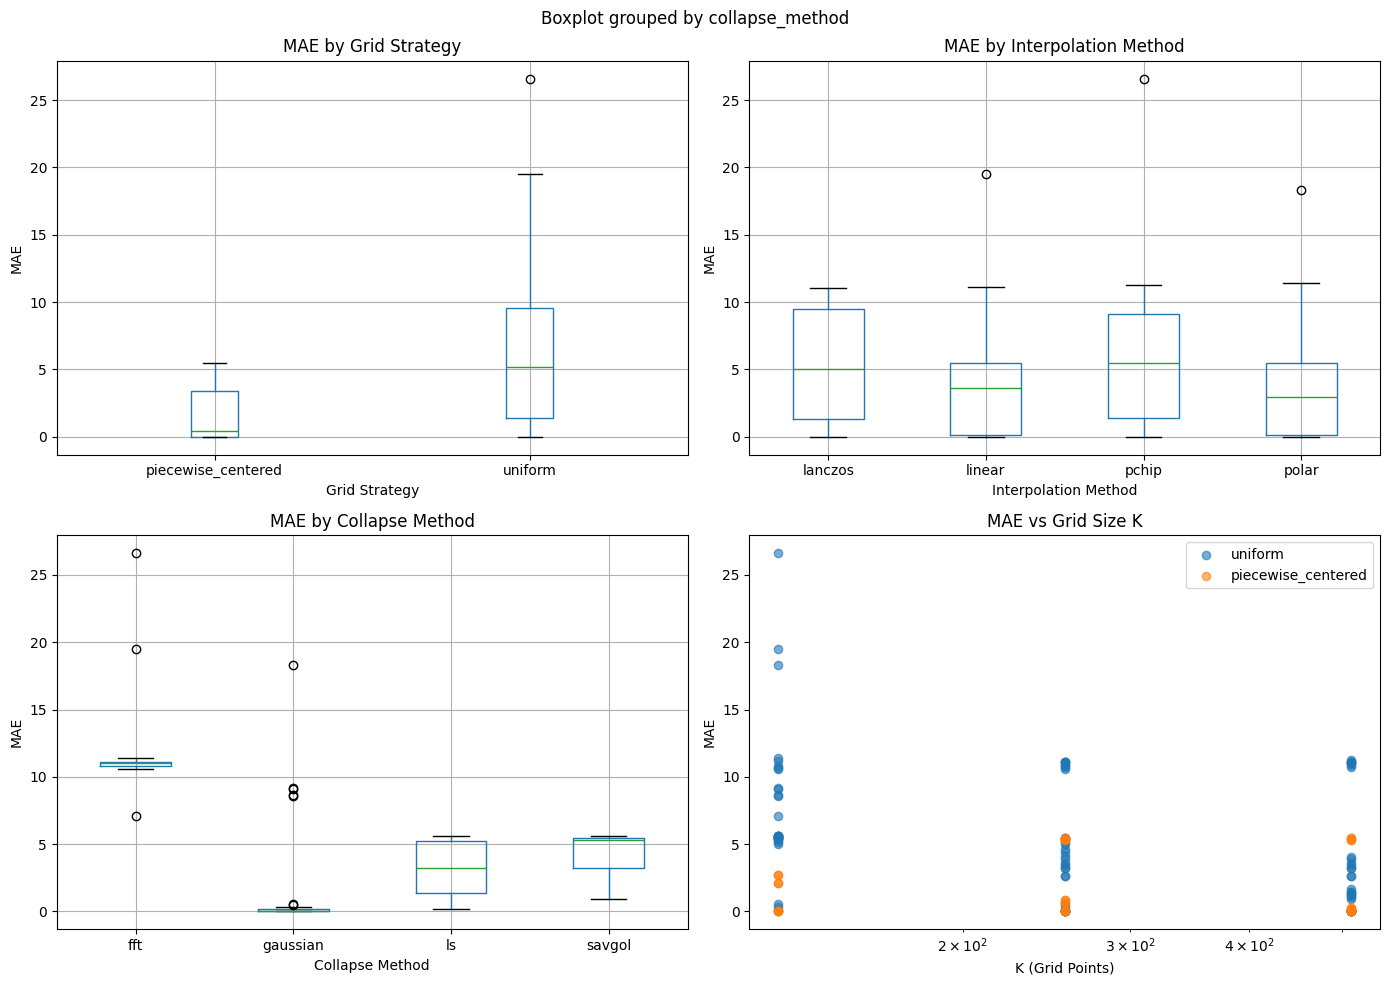


Experiment suite completed!


In [28]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MAE by grid strategy
df_results.boxplot(column='mae', by='grid_strategy', ax=axes[0, 0])
axes[0, 0].set_title('MAE by Grid Strategy')
axes[0, 0].set_xlabel('Grid Strategy')
axes[0, 0].set_ylabel('MAE')

# MAE by interpolation method
df_results.boxplot(column='mae', by='interp_method', ax=axes[0, 1])
axes[0, 1].set_title('MAE by Interpolation Method')
axes[0, 1].set_xlabel('Interpolation Method')
axes[0, 1].set_ylabel('MAE')

# MAE by collapse method
df_results.boxplot(column='mae', by='collapse_method', ax=axes[1, 0])
axes[1, 0].set_title('MAE by Collapse Method')
axes[1, 0].set_xlabel('Collapse Method')
axes[1, 0].set_ylabel('MAE')

# MAE vs K (grid size)
for strategy in df_results['grid_strategy'].unique():
    data = df_results[df_results['grid_strategy'] == strategy]
    axes[1, 1].scatter(data['K'], data['mae'], label=strategy, alpha=0.6)
axes[1, 1].set_title('MAE vs Grid Size K')
axes[1, 1].set_xlabel('K (Grid Points)')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].legend()
axes[1, 1].set_xscale('log')

plt.tight_layout()
plt.show()

print("\nExperiment suite completed!")
